## Image Obfuscation with Pseudonymization
In this notebook we are exploring how to replace entities like names, ids, or addresses by pseudonyms, this is, similar entities of the same class. But we won't stop there, we will also render these fake entities on top of the original images creating a new "impainted" version of the documents.</br>
In order for that to happen successfully, we not only need to pick replacementes from the same class, i.e., names, addresses, etc, but also we need to find replacements that render in a similar manner in the page. Also, the pipeline we will show today will make its best to keep font size consistency between the replacement texts and the surrounding context.</br> 
Let's jump into it!

## Install spark-ocr python package
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar`
- or `secret` for Spark OCR
- `aws_access_key` and `aws_secret_key`for download pretrained models

In [1]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

In [2]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

nlp_secret = ""

spark = start(jar_path=spark_ocr_jar_path)

spark

Spark version: 3.5.0
Spark NLP version: 6.1.1
Spark NLP for Healthcare version: 6.1.0
Spark OCR version: 6.1.0

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-870335ef-edac-4ab1-8f6a-033cf3e2c98d;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;6.1.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	found com.g

In [3]:
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
import sparkocr
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, to_pil_image, display_images_horizontal
from sparkocr.metrics import score
import pkg_resources

# import sparknlp packages
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

In [4]:
from sparknlp.pretrained import PretrainedPipeline

deid_pipeline = PretrainedPipeline("ner_deid_subentity_context_augmented_pipeline", "en", "clinical/models")
stages = deid_pipeline.model.stages

pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setKeepInput(True) \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setWithSpaces(True) \
    .setConfidenceThreshold(70)


stages.insert(0,pdf_to_image)
stages.insert(1,ocr)

custom_ner_converter_internal = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_subentity"]) \
        .setOutputCol("ner_chunk_subentity") \
        .setThreshold(0.6) \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PERSON', 'DATE', 'IDNUM', 'DOCTOR', 'PATIENT', 'MEDICALRECORD', 'PHONE', 'CITY','ZIP'])

stages[7] = custom_ner_converter_internal

deid_obfuscated = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"]) \
    .setOutputCol("obfuscated") \
    .setMode("obfuscate") \
    .setKeepMonth(True) \
    .setKeepYear(True) \
    .setObfuscateDate(True)\
    .setReturnEntityMappings(True) \
    .setKeepTextSizeForObfuscation(True) \
    .setFakerLengthOffset(10) \
    .setMappingsColumn("aux") \
    .setIgnoreRegex(True) \
    .setSeed(40) \
    .setConsistentObfuscation(True) \
    .setDateFormats(["yyyy"])

position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setSmoothCoordinates(True)

drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputChunkMappingCol("aux") \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_patches")  \
    .setPatchImages(True) \
    .setUseContrastTextColor(False) \
    .setFontStyle(FontStyle.PLAIN)

stages.append(deid_obfuscated)
stages.append(position_finder)
stages.append(drawRegions)

new_pipe = Pipeline(stages=stages)

ner_deid_subentity_context_augmented_pipeline download started this may take some time.
Approx size to download 1.6 GB
[ | ]ner_deid_subentity_context_augmented_pipeline download started this may take some time.
Approximate size to download 1.6 GB


25/08/26 21:38:12 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/08/26 21:38:12 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Download done! Loading the resource.
[ / ]

2025-08-26 21:38:15.330617: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[ — ]

2025-08-26 21:38:18.601503: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSub: CPU 
AddV2: CPU 
ScatterAdd: CPU 
NoOp: CPU 
Sqrt: CPU 
UnsortedSegmentSum: CPU 
RealDiv: CPU 
Const: CPU 
StridedSlice: CPU 
RandomUniform: CPU 
Unique: CPU 
Mul: CPU 
Add: CPU 
VariableV2: CPU 
Assign: CPU 
Identity: CPU 
Shape: CPU 
Cast: CPU 
Sub: CPU 
Gat

[OK!]


In [5]:
df = spark.read.format("binaryFile").load("./pdfs/mock_doc.pdf")

result = new_pipe.fit(df).transform(df).cache()

25/08/26 21:38:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Visualize Input Data & Output Data


    Image #0:
    Origin: file:/workspace/visual-nlp-workshop/jupyter/pdfs/mock_doc.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: 5
    Number of channels: 3


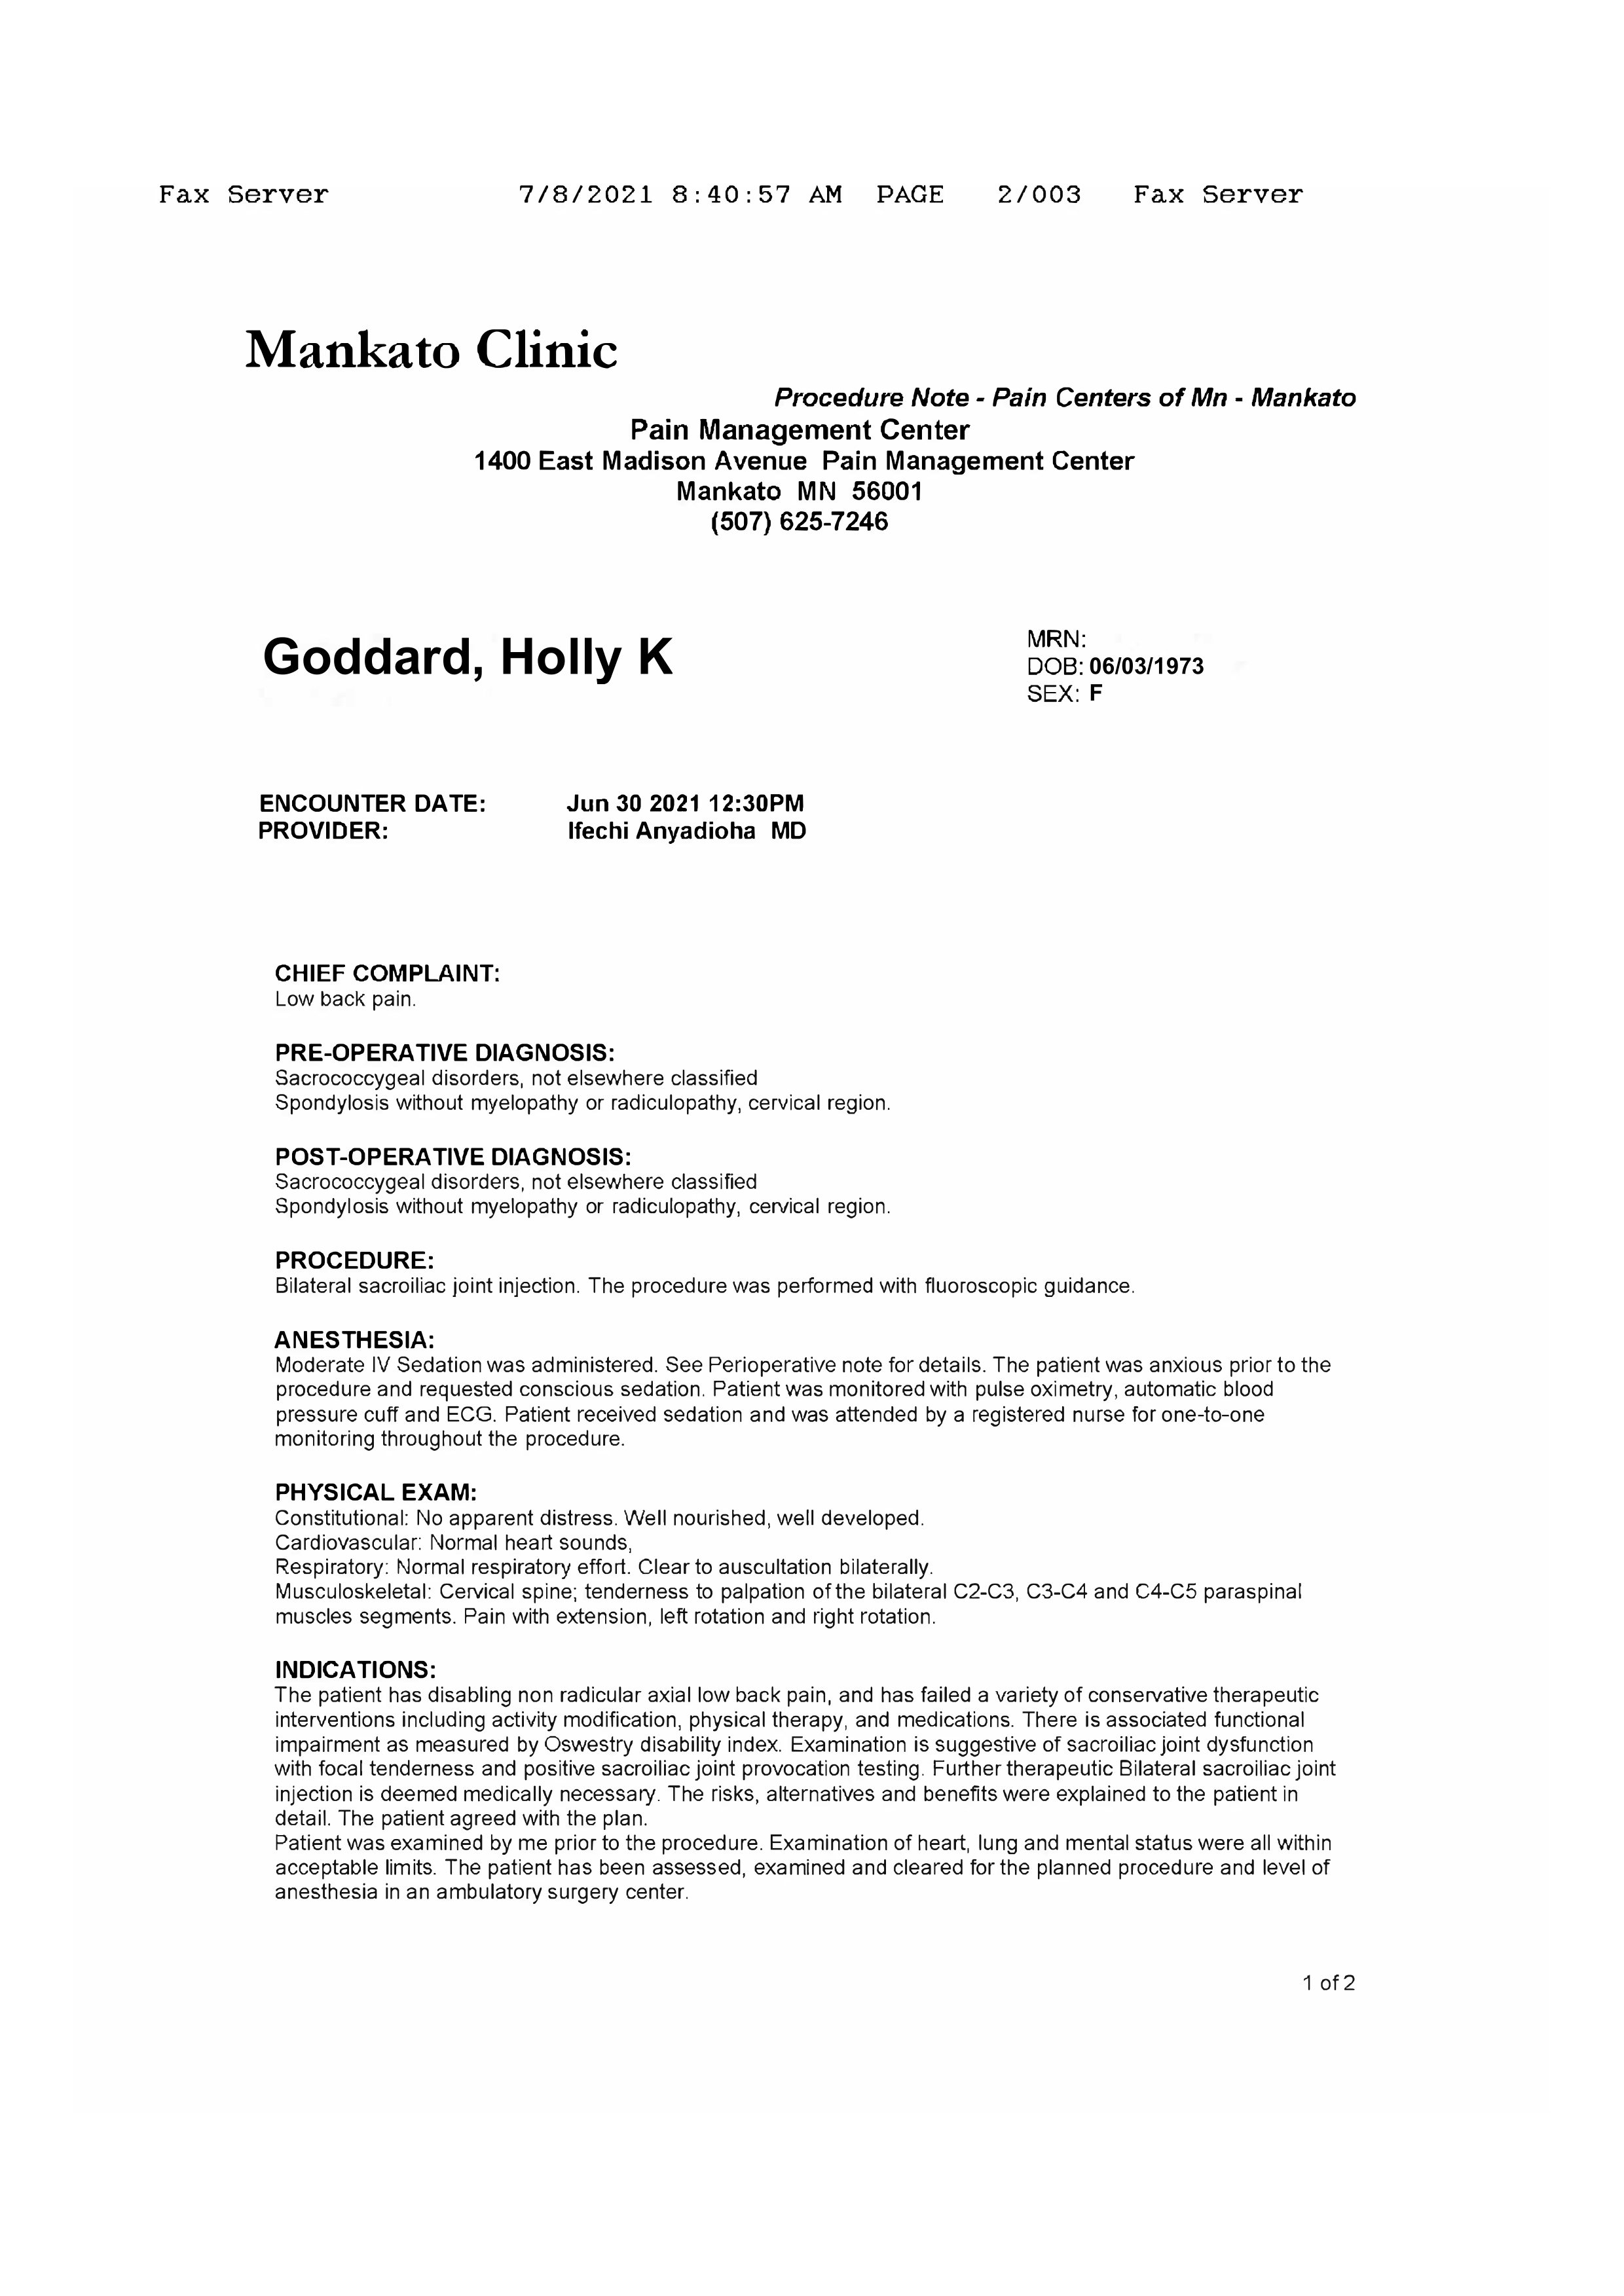

In [6]:
display_images(result, "image_raw")


    Image #0:
    Origin: file:/workspace/visual-nlp-workshop/jupyter/pdfs/mock_doc.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: 5
    Number of channels: 3


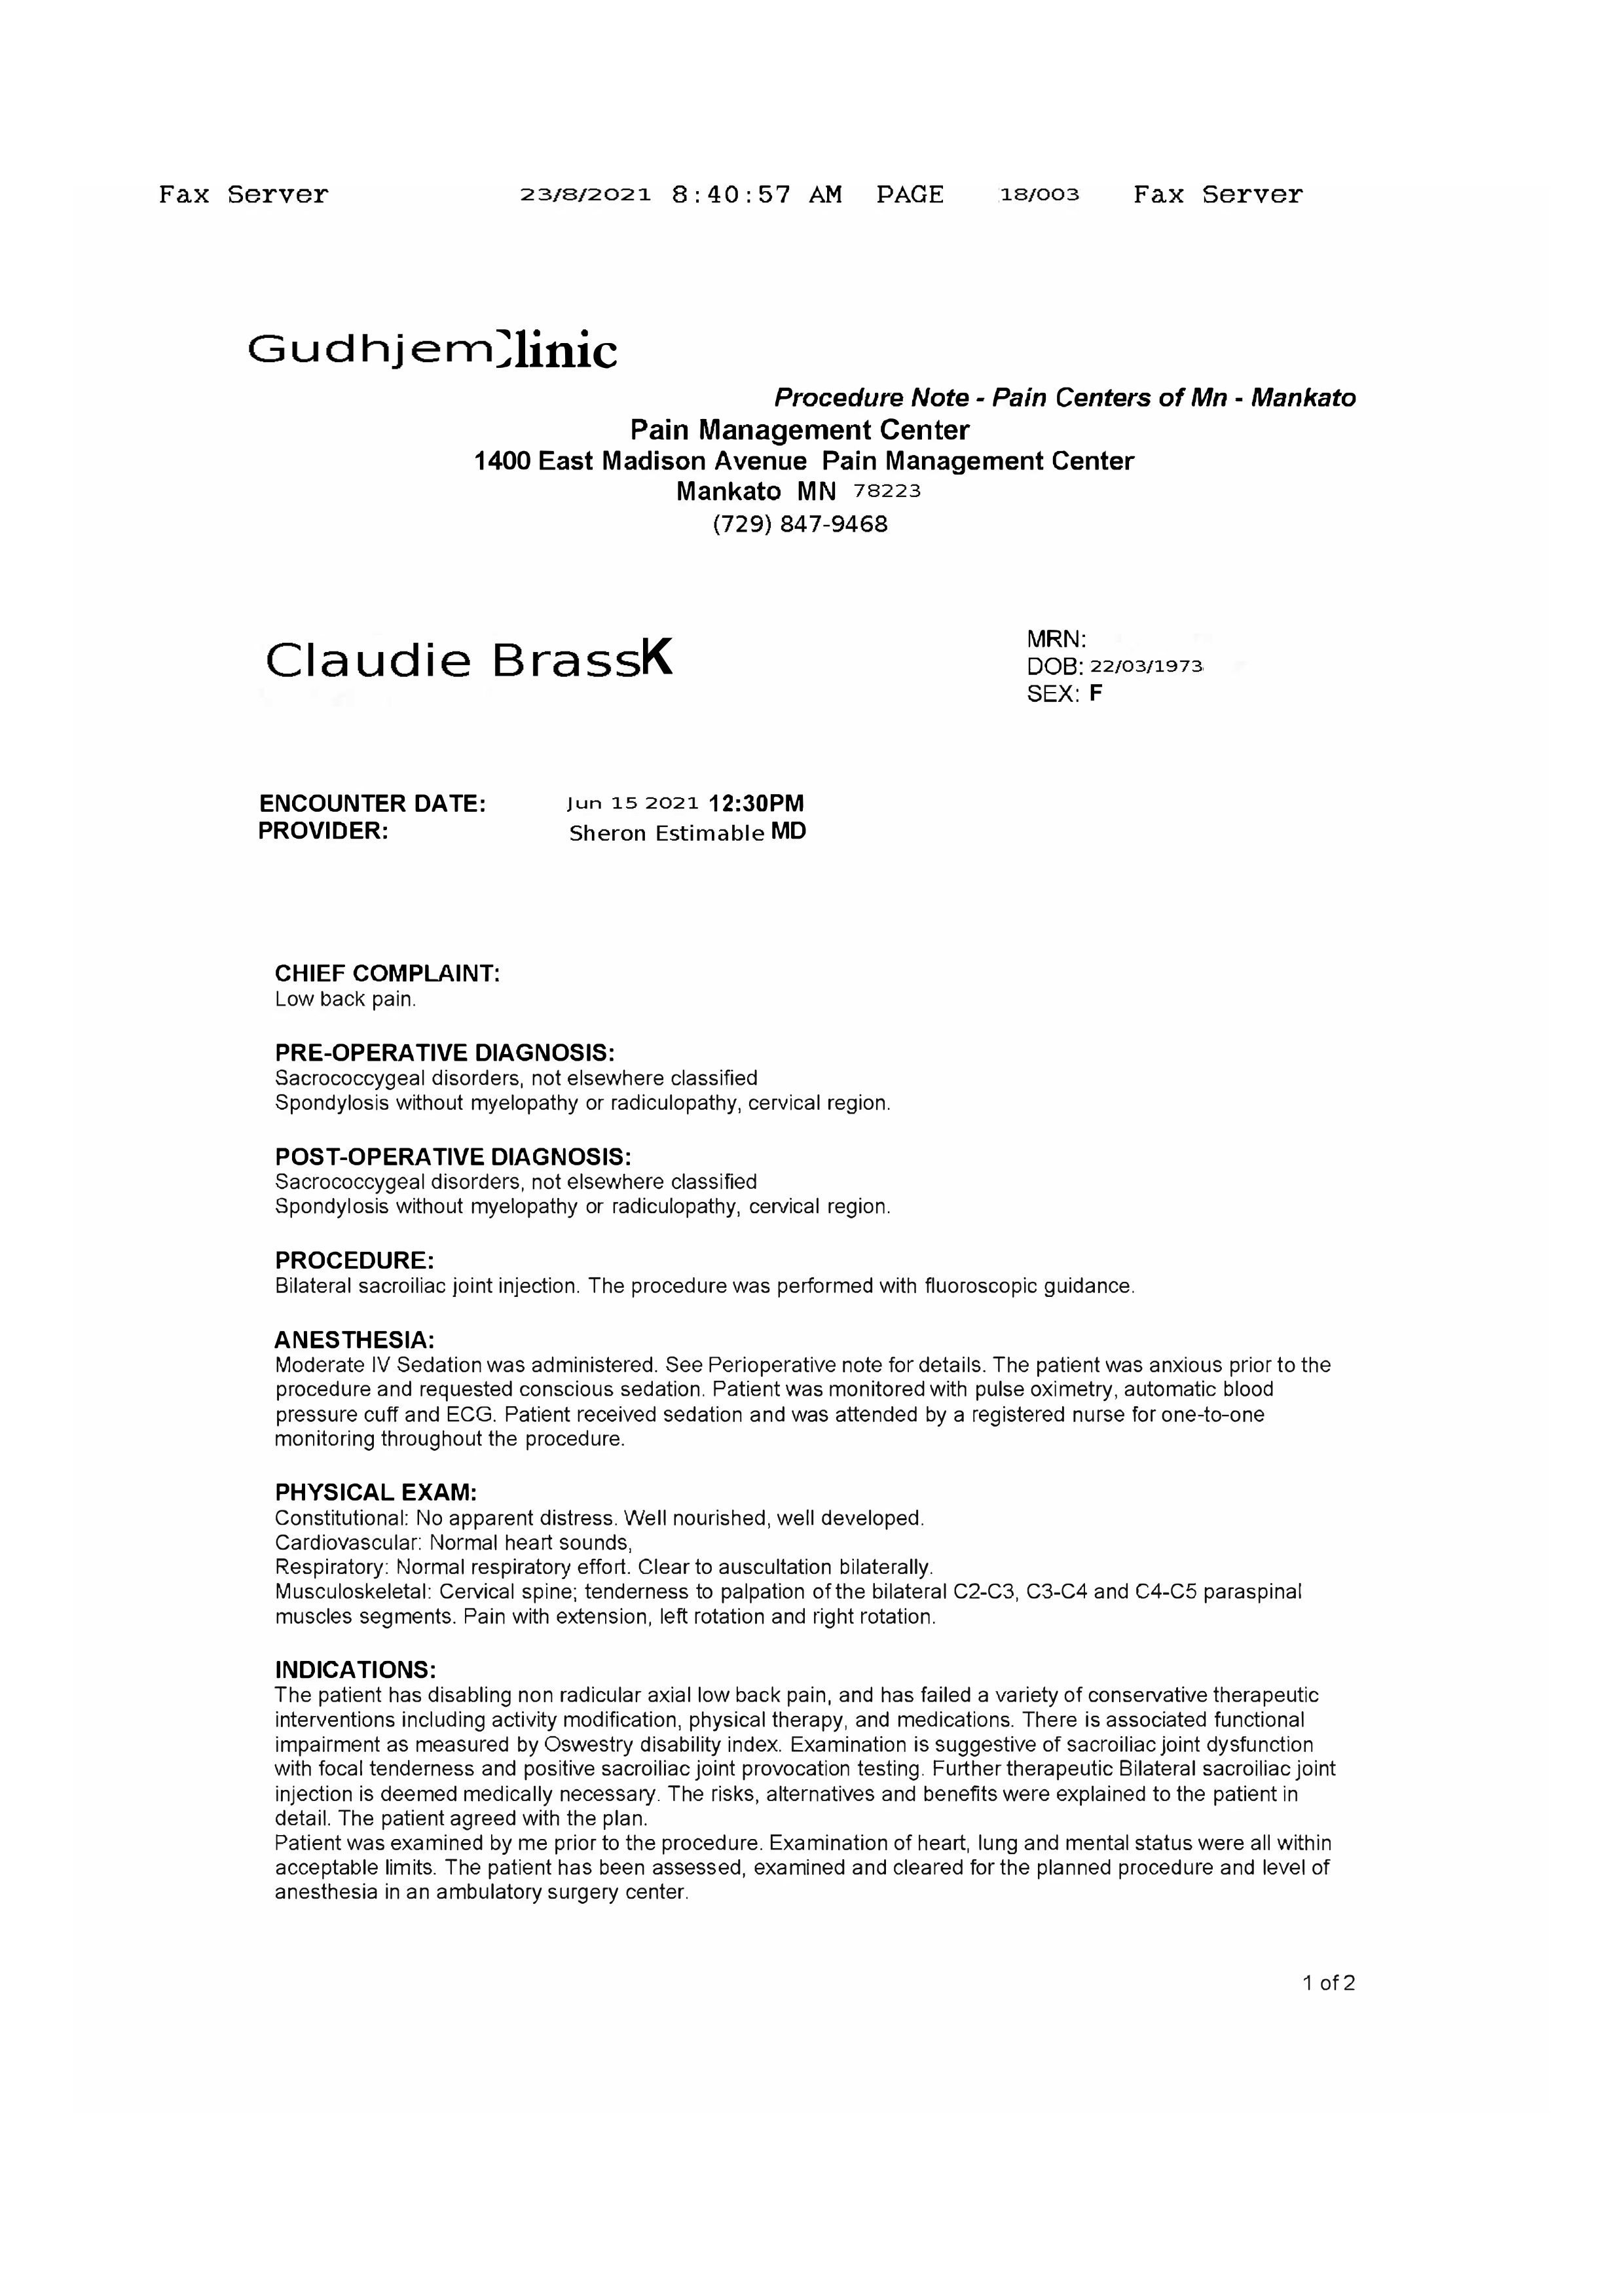

In [7]:
display_images(result, "image_with_patches")

## List all replacements
In the following cell we will take a look at the original entities and the obfuscated versions together with their lengths.

In [8]:
for item in result.select("aux").collect()[0].asDict()["aux"]:
    data = item.asDict()

    orig = data["metadata"]["originalChunk"]
    res = data["result"]
    
    print(f"Original: {orig} Original Length: {len(orig)} Obfuscated: {res} Obfuscated Length: {len(res)}", end="\n\n")

Original: 7/8/2021 Original Length: 8 Obfuscated: 23/8/2021 Obfuscated Length: 9

Original: 2/003 Original Length: 5 Obfuscated: 18/003 Obfuscated Length: 6

Original: Mankato Original Length: 7 Obfuscated: Gudhjem Obfuscated Length: 7

Original: 56001 Original Length: 5 Obfuscated: 78223 Obfuscated Length: 5

Original: (507) 625-7246 Original Length: 14 Obfuscated: (729) 847-9468 Obfuscated Length: 14

Original: Goddard, Holly Original Length: 14 Obfuscated: Claudie Brass Obfuscated Length: 13

Original: 06/03/1973 Original Length: 10 Obfuscated: 22/03/1973 Obfuscated Length: 10

Original: Jun 30 2021 Original Length: 11 Obfuscated: Jun 15 2021 Obfuscated Length: 11

Original: Ifechi Anyadioha Original Length: 16 Obfuscated: Sheron Estimable Obfuscated Length: 16

